### <h2>Arithmatic Expression Solver </h2>
<b><i>Author: Pradeep Mundlik (AI21BTECH11022)</i></b>

<ul>
<li> Image Classification with CNN
<li> Object Detection (Open CV)
<li> Image Processing
</ul>

In [123]:
import numpy as np
import cv2
import os
import torch
from torch import nn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

#### Importing and loading data

In [124]:
# listing out directories of data
symbols = os.listdir('archive/train/')
symbols

['div',
 'two',
 'one',
 'equal',
 'seven',
 'zero',
 'plus',
 'minus',
 'six',
 'decimal',
 'five',
 'three',
 'eight',
 'four',
 'times',
 'nine']

In [125]:
num_to_sym = {i:x for (i,x) in enumerate(symbols)}
sym_to_num = {x:i for (i,x) in enumerate(symbols)}
word_to_symbol = {
    'div': '/',
    'two': '2',
    'one': '1',
    'equal': '=',
    'seven': '7',
    'zero': '0',
    'plus': '+',
    'minus': '-',
    'six': '6',
    'decimal': '.',
    'five': '5',
    'three': '3',
    'eight': '8',
    'four': '4',
    'times': '*',
    'nine': '9'
}
sym_to_num

{'div': 0,
 'two': 1,
 'one': 2,
 'equal': 3,
 'seven': 4,
 'zero': 5,
 'plus': 6,
 'minus': 7,
 'six': 8,
 'decimal': 9,
 'five': 10,
 'three': 11,
 'eight': 12,
 'four': 13,
 'times': 14,
 'nine': 15}

In [126]:
data = []
labels = []
dim = (32,32)

for sym in symbols:
    
    path = 'archive/train/'+sym+'/'
    for img in os.listdir(path):
        x=cv2.imread(path+img,cv2.IMREAD_GRAYSCALE)
        # print(x.shape)
        data.append(cv2.resize(x, dim, interpolation=cv2.INTER_AREA))
        labels.append(sym_to_num[sym])
        
print(len(data),len(labels))

7557 7557


In [127]:
# data loader for shuffling data and dividing into batches
def dataloader(data,labels):
    data,labels = shuffle(data,labels)

    batches=[]

    for i in range(0,labels.shape[0]-255,256):
        batches.append({data[i:i+256],labels[i:i+256]})
        
    return batches

# to calculate accuracy of model
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)).item()

In [128]:
data = torch.tensor(np.array(data))
data=data/255
data = data.reshape([7557,1,32,32])
labels = torch.tensor(labels)
batches = dataloader(data,labels)

#### CNN Classifier

In [129]:
class model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.network=nn.Sequential(
            # k*1*32*32
            nn.Conv2d(1, 32, kernel_size=3, padding=1), # k*32*32*32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # k*64*32*32
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # k*128*16*16
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # k*128*16*16
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # k*256*8*8
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # k*256*8*8
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024), # k*1024
            nn.ReLU(),
            nn.Linear(1024, 512), # k*512
            nn.ReLU(),
            nn.Linear(512, 16) # k*16
            )
    
    def forward(self,x):
        return self.network(x)
    
    # function for validation loss
    def evaluate(self,batches):
        self.eval()
        for batch in batches:
            images, labels = batch 
            out = self(images)                    # Generate predictions
            loss = nn.functional.cross_entropy(out, labels)   # Calculate loss
            acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach().item(), 'val_acc': acc}

    # for training model
    def fit(self, batches, optim, lr, max_epochs):
        
        info = [] # list to store val loss, val accuracy and training loss for each epoach

        for param in self.parameters():
            param.requires_grad=True
            
        optimizer = optim(self.parameters(), lr)

        for epoch in range(max_epochs):

            self.train()
            train_losses = [] # list to store loss for each batch

            for batch in batches:

                # training step 
                imgs, labels = batch
                out = self(imgs)
                loss = nn.functional.cross_entropy(out,labels)
                train_losses.append(loss)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            result = self.evaluate(batches)
            result['train_loss'] = torch.stack(train_losses).mean().item()
            info.append(result)
            print(f'Epoach {epoch}: {result}')

        return info
    
    # prediction function to predict label from model
    def pred(self, data):
        out = self(data)
        return torch.argmax(out,1)


##### Training Classifier

In [130]:
clf = model()
clf

model(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024,

In [131]:
c = clf.fit(batches,lr=0.001, optim=torch.optim.Adam, max_epochs=15)

Epoach 0: {'val_loss': 2.7745208740234375, 'val_acc': 0.046875, 'train_loss': 2.7700846195220947}
Epoach 1: {'val_loss': 2.2211458683013916, 'val_acc': 0.203125, 'train_loss': 2.577150583267212}
Epoach 2: {'val_loss': 1.6096394062042236, 'val_acc': 0.40625, 'train_loss': 1.942267656326294}
Epoach 3: {'val_loss': 1.2626436948776245, 'val_acc': 0.57421875, 'train_loss': 1.3381680250167847}
Epoach 4: {'val_loss': 0.7543678879737854, 'val_acc': 0.7734375, 'train_loss': 1.1157805919647217}
Epoach 5: {'val_loss': 0.40713074803352356, 'val_acc': 0.8671875, 'train_loss': 0.6249153017997742}
Epoach 6: {'val_loss': 0.26855218410491943, 'val_acc': 0.921875, 'train_loss': 0.42304548621177673}
Epoach 7: {'val_loss': 0.17405247688293457, 'val_acc': 0.9609375, 'train_loss': 0.25816720724105835}
Epoach 8: {'val_loss': 0.14267009496688843, 'val_acc': 0.96484375, 'train_loss': 0.20877698063850403}
Epoach 9: {'val_loss': 0.0710214376449585, 'val_acc': 0.98046875, 'train_loss': 0.13707393407821655}
Epoach

##### Plots of loss and accuracy for classifier

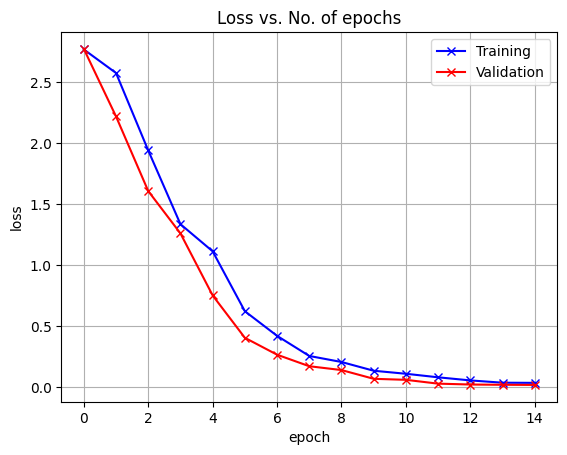

In [132]:
train_losses = [x.get('train_loss') for x in c]
val_losses = [x['val_loss'] for x in c]
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs')
plt.grid()

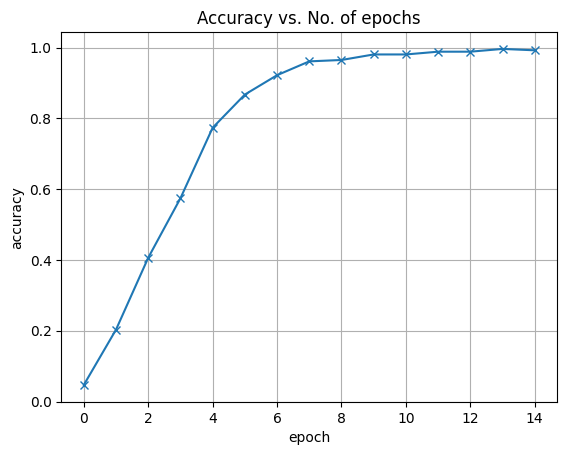

In [133]:
accuracies = [x['val_acc'] for x in c]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')
plt.grid()

##### Test over a sample

In [139]:
# testing our model over one data sample
x=cv2.imread('archive/eval/decimal val/272.jpg',cv2.IMREAD_GRAYSCALE)
x=cv2.resize(x, (32,32), interpolation=cv2.INTER_AREA)
x=torch.tensor(x,dtype=torch.float32).reshape([1,1,32,32])
x=x/255

label = clf.pred(x).item()
out = clf(x)
# print(torch.argmax(out[0]).item(),label)
print(num_to_sym[label])
print(out)

decimal
tensor([[ -4.7446,   4.2038,  -4.8286,  -2.9474,  -5.2754,  -0.4191,  -0.7214,
          -0.5221,  -5.3739,  14.3317,  -4.6163,  -5.2440,  -4.7909,  -9.1354,
          -3.3977, -16.0112]], grad_fn=<AddmmBackward0>)


#### Input processing

##### Function for detection symbols from input image 


In [197]:
def symbol_detection(img_path):

    image = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)  # Load image in grayscale

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # print(image.shape)
    # print(blurred.shape)

    # Apply adaptive thresholding to convert the image into binary
    _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    digits = {}

    for contour in contours:
        
        # Get bounding rectangle of the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Ignore small contours
        if cv2.contourArea(contour) < 500:
            continue

        # Extract the digit ROI (Region of Interest)
        digit_roi = thresholded[y:y + h + 20, x - 20:x + w + 20]

        # Resize the digit ROI to a fixed size
        resized_digit = cv2.resize(digit_roi, dim)

        # Add the resized digit to the digits list
        # digits.append({x:(255.0-resized_digit)/255.0})
        digits[x]=(255.0-resized_digit)/255.0

        # print(x,h,y,w)
        cv2.rectangle(image, (x - 20, y - 20), 
                        (x + w + 10, y + h ), (0,255,0),
                        2)
    
    # sorting symbols from left to right
    digits = list(dict(sorted(digits.items(), key=lambda x:x[0])).values())
    n = len(digits)
    print('Number of symbols detected:',n)
    print('Shape of each part:',digits[0].shape)

    plt.imshow(image,cmap='gray')
    plt.show()
    # cv2.imshow("1",image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(digits[i],cmap='gray')
        
    return digits,n

##### Input 1

Number of symbols detected: 3
Shape of each part: (32, 32)


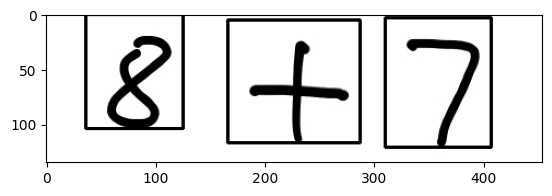

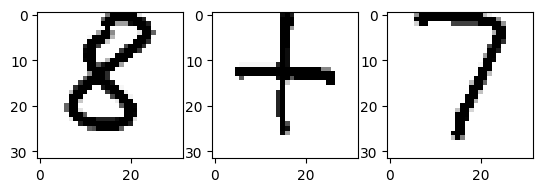

In [182]:
digits, n = symbol_detection('input1.png')

In [183]:
x = torch.tensor(digits,dtype=torch.float32)
x = torch.reshape(x,[n,1,32,32])
y = clf.pred(x)
exp = ""
for i in range(n):
    # print(f'Symbol {i+1}:',word_to_symbol[num_to_sym[y[i].item()]])
    exp += word_to_symbol[num_to_sym[y[i].item()]]

print('Expression:',exp, '=', eval(exp))

Expression: 8+7 = 15


##### Input 2

Number of symbols detected: 5
Shape of each part: (32, 32)


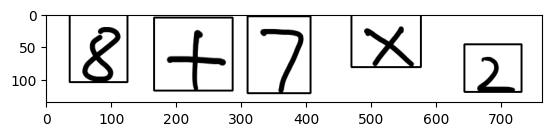

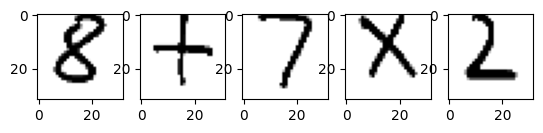

In [184]:
digits, n = symbol_detection('input2.png')

In [185]:
x = torch.tensor(digits,dtype=torch.float32)
x = torch.reshape(x,[n,1,32,32])
y = clf.pred(x)
exp = ""
for i in range(n):
    # print(f'Symbol {i+1}:',word_to_symbol[num_to_sym[y[i].item()]])
    exp += word_to_symbol[num_to_sym[y[i].item()]]

print('Expression:',exp, '=', eval(exp))

Expression: 8+7*2 = 22


##### Input 3

Number of symbols detected: 3
Shape of each part: (32, 32)


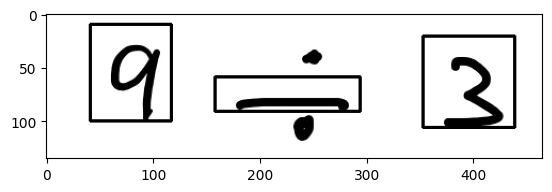

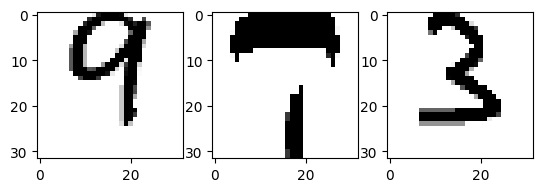

In [198]:
digits, n = symbol_detection('input3.png')

In [200]:
x = torch.tensor(digits,dtype=torch.float32)
x = torch.reshape(x,[n,1,32,32])
y = clf.pred(x)
exp = ""
for i in range(n):
    # print(f'Symbol {i+1}:',word_to_symbol[num_to_sym[y[i].item()]])
    exp += word_to_symbol[num_to_sym[y[i].item()]]

print('Expression:',exp, '=', eval(exp))

Expression: 933 = 933


<p><b>NOTE:</b> Above is failed test case